# Restaurant to Open at Yogyakarta, Indonesia

## 1. Introduction

Yogyakarta is a really diverse place in Indonesia. All sort of people are here in Yogyakarta to study, travel, business, permananent residence and many others. These groups have a tendency to cluster to a certain location in Yogyakarta. Thus, this clustering also affects their food choices. Since their palates is affected, so does the success of a certain restaurants being open on certain locations. 

This project is meant to help **entrepreneurs, local cooks and chefs** to better understand the correlation between the location and the best type of restaurant to be opened based on local palate. By choosing the best location based on the type of restaurant they're going to open, hopefully they could minimize the risk of bankruptcy and maximize profit.

To better understand the palate preferences in Yogyakarta, foursquare venue data will gives us relevant information about restaurant type and it's location. By using machine learning algorithm such as KKN, we can group neighborhoods that have similar food palates based on nearby restaurants thus giving us cluster of food preferences. 

## 2. Data

Data used in this project:
<br>**1.** Data retrieved from https://kodepos.nomor.net/_kodepos.php?_i=kota-kodepos&daerah=Provinsi&jobs=DI+Yogyakarta&perhal=400&urut=10&asc=00001111&sby=110000&no1=2 for region names and postal code information.
<br>**2.** Geopy library to find geographical location information.
<br>**3.** Using Foursquare API to find nearby restaurants information such as their location and types of dishes they sell.

## 3. Methodology

### 3.1. Acquiring and Data Cleaning

#### 3.1.1. Importing necessary libraries

In [1]:
import time # for time delay while working with API

import requests # library to handle requests

import bs4 # library to parse webpages

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
import geopy.geocoders

import json # library to handle JSON files

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# k-means from clustering stage
from sklearn.cluster import KMeans

# Map rendering library
import folium

# regular expressions
import re

#### 3.1.2. Scraping Region Name and Postal Code Data from Website

In [2]:
# Download the webpage
url = 'https://kodepos.nomor.net/_kodepos.php?_i=cari-kodepos&daerah=&jobs=Yogyakarta&perhal=500&urut=&asc=000101&sby=010000&no1=2'
res = requests.get(url)
res.raise_for_status()

In [3]:
# Create an beautifulSoup object
from bs4 import BeautifulSoup
yogyakarta_soup = bs4.BeautifulSoup(res.text)

In [4]:
# Selecting all elements inside the corresponding tags
elements = yogyakarta_soup.select('a')

In [5]:
# Finding the lengths
len(elements)

3126

In [6]:
# Restrict More
loc_containers = yogyakarta_soup.find_all('a', class_ = 'ktw')
print(type(loc_containers))
print(len(loc_containers))

<class 'bs4.element.ResultSet'>
3089


In [7]:
#Creating a list
lst = []

for i in range(0,3081,7):
    kodepos, desa, kecamatan, kota  = loc_containers[i+1].text, loc_containers[i+2].text, loc_containers[i+4].text, loc_containers[i+5].text
    lst.append([kodepos, desa, kecamatan, kota,0,0])
lst[1:10]   



[['55752', 'Argodadi', 'Sedayu', 'Bantul', 0, 0],
 ['55752', 'Argomulyo', 'Sedayu', 'Bantul', 0, 0],
 ['55583', 'Argomulyo (Argo Mulyo)', 'Cangkringan', 'Sleman', 0, 0],
 ['55752', 'Argorejo', 'Sedayu', 'Bantul', 0, 0],
 ['55752', 'Argosari', 'Sedayu', 'Bantul', 0, 0],
 ['55225', 'Baciro', 'Gondokusuman', 'Yogyakarta', 0, 0],
 ['55295', 'Balecatur', 'Gamping', 'Sleman', 0, 0],
 ['55811', 'Baleharjo', 'Wonosari', 'Gunung Kidul', 0, 0],
 ['55883', 'Balong', 'Girisubo', 'Gunung Kidul', 0, 0]]

In [8]:
# Checking Data Length
print('Now we have {} rows of relevant data.'.format(len(lst)))

Now we have 441 rows of relevant data.


#### 3.1.3. Converting to Pandas Dataframe

In [9]:
#Converting to Pandas Dataframe
df = pd.DataFrame(lst, columns=['Postal Code', 'Borough', 'Regency', 'City', 'Latitude', 'Longitude'])
df.head()

,Postal Code,Borough,Regency,City,Latitude,Longitude
0,55294,Ambarketawang,Gamping,Sleman,0,0
1,55752,Argodadi,Sedayu,Bantul,0,0
2,55752,Argomulyo,Sedayu,Bantul,0,0
3,55583,Argomulyo (Argo Mulyo),Cangkringan,Sleman,0,0
4,55752,Argorejo,Sedayu,Bantul,0,0


In [10]:
df.shape

(441, 6)

#### 3.1.4. Early Visualization

In [11]:
# Adding Coordinate
for i in range(len(df)):
    time.sleep(2.5)
    address = df.iloc[i,1]
    geolocator = Nominatim(user_agent='opening_restaurant_yogyakarta')
    location = geolocator.geocode(address)
    if location == None:
        continue
    latitude = location.latitude
    longitude = location.longitude
    df.iloc[i,4] = latitude
    df.iloc[i,5] = longitude
df.head()

,Postal Code,Borough,Regency,City,Latitude,Longitude
0,55294,Ambarketawang,Gamping,Sleman,-7.805396,110.317874
1,55752,Argodadi,Sedayu,Bantul,-7.842437,110.246590
2,55752,Argomulyo,Sedayu,Bantul,-7.670610,110.457459
3,55583,Argomulyo (Argo Mulyo),Cangkringan,Sleman,-7.664847,110.463854
4,55752,Argorejo,Sedayu,Bantul,-7.821616,110.262355


In [12]:
# Get the yogyakarta "central" point
yogyakarta_address = 'yogyakarta, indonesia'
geolocator = Nominatim(user_agent='opening_restaurant_london')
location = geolocator.geocode(yogyakarta_address)
yog_lat = location.latitude
yog_lon = location.longitude
print('The geograpical coordinate of {0} are {1}, {2}.'.format(yogyakarta_address, yog_lat, yog_lon))

The geograpical coordinate of yogyakarta, indonesia are -7.8011945, 110.364917.


In [13]:
# Building a map
yog_map = folium.Map(location=[yog_lat, yog_lon], zoom_start=10)

# add markers to map
for lat, lng, bor in zip(df['Latitude'], df['Longitude'], df['Borough']):
    label = '{}'.format(bor)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        ).add_to(yog_map)
    
yog_map

Seems like some data point is off, as it may interrupt our analysis later on we need to drop it!

#### 3.1.5. Data Cleaning

In [18]:
# Substitute all zeros by NAN
df = df.replace(0, np.nan)

# Drop all rows containing NAN
df.dropna(subset=['Latitude', 'Longitude'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
print('Now the Yogyakarta dataframe has {0} data rows.'.format(df.shape[0]))

Now the Yogyakarta dataframe has 398 data rows.


In [15]:
# Dropping data points that are too far from Yogyakarta region
# Defining Border Latitude and Longitude
sidorejo_address = 'Sidorejo, Indonesia'
geolocator = Nominatim(user_agent='opening_restaurant_london')
location = geolocator.geocode(sidorejo_address)
sid_lat = location.latitude
sid_lon = location.longitude
print('The top border coordinate of {0} are {1}.'.format(yogyakarta_address, sid_lat))

jangkaran_address = 'Jangkaran, Indonesia'
geolocator = Nominatim(user_agent='opening_restaurant_london')
location = geolocator.geocode(jangkaran_address)
jan_lat = location.latitude
jan_lon = location.longitude
print('The geograpical coordinate of {0} are {1}.'.format(jangkaran_address,jan_lon))

songbanyu_address = 'Songbanyu, Indonesia'
geolocator = Nominatim(user_agent='opening_restaurant_london')
location = geolocator.geocode(songbanyu_address)
son_lat = location.latitude
son_lon = location.longitude
print('The geograpical coordinate of {0} are {1}.'.format(songbanyu_address, son_lon))


The top border coordinate of yogyakarta, indonesia are -7.5772879500000005.
The geograpical coordinate of Jangkaran, Indonesia are 110.02198723370307.
The geograpical coordinate of Songbanyu, Indonesia are 110.81849685170565.


In [16]:
df=df[df.Longitude<=110.81849685170565]
df.reset_index(drop=True, inplace=True)

df=df[df.Longitude>=110.02198723370307]
df.reset_index(drop=True, inplace=True)

df=df[df.Latitude<=-7.5772879500000005]
df.reset_index(drop=True, inplace=True)

df.shape

(398, 6)

lets check once again

In [17]:
# Building a map
yog_map = folium.Map(location=[yog_lat, yog_lon], zoom_start=10)

# add markers to map
for lat, lng, bor in zip(df['Latitude'], df['Longitude'], df['Borough']):
    label = '{}'.format(bor)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        ).add_to(yog_map)
    
yog_map

### 3.2. Exploring Restaurants in Yogyakarta

#### 3.2.1. Collecting the Restaurants

Collecting nearby restaurants information such as it's name and it's location

In [19]:
VERSION = 20200721
LIMIT = 100

# Defining a function to collect restaurant nearby in 500m radius
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={0}&client_secret={1}&v={2}&ll={3},{4}&radius={5}&limit={6}&query=restaurant'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            #v['venue']['location']['lat'], 
            #v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  #'Venue Latitude', 
                  #'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
yogyakarta_venues = getNearbyVenues(names=df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                   )

In [22]:
print(yogyakarta_venues.shape)
yogyakarta_venues.head()

(1547, 5)


,Borough,Latitude,Longitude,Venue,Venue Category
0,Ambarketawang,-7.805396,110.317874,Paradise Resto,Javanese Restaurant
1,Ambarketawang,-7.805396,110.317874,Rumah Makan Paradise,Indonesian Restaurant
2,Ambarketawang,-7.805396,110.317874,RM Padang Murah Meriah,Asian Restaurant
3,Ambarketawang,-7.805396,110.317874,Paradise Resto/ Restaurant Paradise,Indonesian Restaurant
4,Argomulyo,-7.670610,110.457459,Sate pak lempong,Halal Restaurant


In [23]:
yogyakarta_venues[['Borough', 'Venue']].groupby('Borough').count()

,Venue
Borough,
Ambarketawang,4
Argomulyo,2
Argomulyo (Argo Mulyo),8
Argorejo,6
Argosari,3
Baciro,14
Balecatur,4
Baleharjo,6
Banaran,10


#### Borough with no data of restaurants

In [24]:
x = yogyakarta_venues[['Borough', 'Venue']].groupby('Borough').count().shape[0]
y = df.shape[0]
empty_locations = []
if x != y:
    print('Missing data for {0} locations:'.format(y-x))
    # And print them
    for i in range(df.shape[0]):
        loc = df.iloc[i,1]
        k = 0
        for j in range(yogyakarta_venues.shape[0]):
            if loc == yogyakarta_venues.iloc[j,0]:
                k += 1
        if k == 0:
            print(i,loc)
            empty_locations.append(loc)

Missing data for 191 locations:
1 Argodadi
9 Balong
16 Banjarejo
17 Banjaroyo
22 Banyuroto
23 Banyusoco
27 Bedoyo
28 Beji
29 Beji
31 Bendung
36 Bleberan
37 Bojong
41 Bugel
46 Canden
47 Candibinangun (Candi Binangun)
48 Candirejo
49 Candirejo (Candi Rejo)
50 Caturharjo (Catur Harjo)
55 Dadapayu
57 Demangrejo
58 Dengok
59 Dlingo
62 Donomulyo
63 Donotirto
68 Garongan
69 Gayamharjo (Gayam Harjo)
71 Genjahan
72 Gerbosari
73 Getas
74 Gilangharjo
75 Giriasih
76 Giricahyo
77 Giriharjo
78 Girijati
79 Girikarto
80 Girikerto (Giri Kerto)
81 Girimulyo
82 Giring
83 Giripanggung
84 Giripurwo
85 Giripurwo
88 Girisuko
89 Giritirto
90 Giriwungu
93 Gombang
94 Gotakan
96 Gulurejo
98 Guwosari
100 Hargomulyo
103 Hargotirto
107 Jangkaran
108 Janten
109 Jatiayu (Jati Ayu)
110 Jatimulyo
111 Jatimulyo
113 Jepitu
114 Jerukwudel
116 Jogotirto (Jogo Tirto)
118 Kaliagung
119 Kaligintung
120 Kalirejo
121 Kalitekuk
123 Kampung
124 Kanigoro
125 Kanoman
126 Karangasem (Karang Asem)
127 Karangasem (Karang Asem)
128 Kar

In [25]:
print('There are {0} uniques categories.'.format(len(yogyakarta_venues['Venue Category'].unique())))

There are 62 uniques categories.


#### 3.2.2. Classifying Category of Restaurants

In [26]:
yogyakarta_venues['Venue Category'].unique()

array(['Javanese Restaurant', 'Indonesian Restaurant', 'Asian Restaurant',
       'Halal Restaurant', 'Food Truck', 'Diner', 'American Restaurant',
       'Restaurant', 'Café', 'Soup Place',
       'Vegetarian / Vegan Restaurant', 'Noodle House', 'Gastropub',
       'Balinese Restaurant', 'Chinese Restaurant', 'Food',
       'Breakfast Spot', 'BBQ Joint', 'Steakhouse',
       'Fast Food Restaurant', 'Bakery', 'Fried Chicken Joint',
       'Betawinese Restaurant', 'Food Court', 'Ramen Restaurant',
       'Japanese Restaurant', 'Italian Restaurant', 'Thai Restaurant',
       'Burger Joint', 'Seafood Restaurant', 'Dumpling Restaurant',
       'Snack Place', 'Pizza Place', 'Donut Shop',
       'Middle Eastern Restaurant', 'Korean Restaurant', 'Salad Place',
       'Shabu-Shabu Restaurant', 'Manadonese Restaurant', 'Bistro',
       'Indonesian Meatball Place', 'Comfort Food Restaurant',
       'Cafeteria', 'Eastern European Restaurant', 'Bagel Shop', 'Buffet',
       'Afghan Restaurant', 'G

**To simplify the type of restaurants, every type of restaurants with country name on it will be grouped into it's continent's. Exception for Indonesian restaurants and since the study is on Yogyakarta, it may blow the number of Asian Restaurants.**

In [27]:
indonesian_restaurant = ['Indonesian Meatball Place','Javanese Restaurant', 'Indonesian Restaurant','Balinese Restaurant','Betawinese Restaurant','Manadonese Restaurant','Padangnese Restaurant','Sundanese Restaurant']
asian_restaurant = ['Dim Sum Restaurant','Shabu-Shabu Restaurant','Ramen Restaurant','Asian Restaurant','Chinese Restaurant','Japanese Restaurant','Thai Restaurant','Korean Restaurant','Malay Restaurant']
european_restaurant = ['Creperie','Pizza Place','Italian Restaurant','Eastern European Restaurant','German Restaurant','Spanish Restaurant', 'French Restaurant']
middle_eastern = ['Middle Eastern Restaurant','Afghan Restaurant','Halal Restaurant']
north_american = ['American Restaurant','BBQ Joint','Bagel Shop']
south_american = ['Burrito Place','Cuban Restaurant','Argentinian Restaurant']
fast_food=['Fast Food Restaurant','Fried Chicken Joint','Burger Joint','Wings Joint','Fish & Chips Shop']
food_court=['Food Court','Cafeteria']
street_food=['Snack Place','Food Stand','Food Truck']
bakery=['Bakery','Donut Shop','Sandwich Place']
vegan=['Vegetarian / Vegan Restaurant','Salad Place']

yogyakarta_venues['Venue Category'] = yogyakarta_venues['Venue Category'].replace(indonesian_restaurant,'Indonesian Restaurant')
yogyakarta_venues['Venue Category'] = yogyakarta_venues['Venue Category'].replace(asian_restaurant,'Asian Restaurant')
yogyakarta_venues['Venue Category'] = yogyakarta_venues['Venue Category'].replace(european_restaurant,'European Restaurant')
yogyakarta_venues['Venue Category'] = yogyakarta_venues['Venue Category'].replace(middle_eastern,'Middle Eastern Restaurant')
yogyakarta_venues['Venue Category'] = yogyakarta_venues['Venue Category'].replace(north_american,'North American Restaurant')
yogyakarta_venues['Venue Category'] = yogyakarta_venues['Venue Category'].replace(south_american,'South American Restaurant')
yogyakarta_venues['Venue Category'] = yogyakarta_venues['Venue Category'].replace(fast_food,'Fast Food Restaurant')
yogyakarta_venues['Venue Category'] = yogyakarta_venues['Venue Category'].replace(food_court,'Food Court')
yogyakarta_venues['Venue Category'] = yogyakarta_venues['Venue Category'].replace(street_food,'Street Food')
yogyakarta_venues['Venue Category'] = yogyakarta_venues['Venue Category'].replace(bakery,'Bakery')
yogyakarta_venues['Venue Category'] = yogyakarta_venues['Venue Category'].replace(vegan,'Vegetarian / Vegan Restaurant')

yogyakarta_venues['Venue Category'].unique()

array(['Indonesian Restaurant', 'Asian Restaurant',
       'Middle Eastern Restaurant', 'Street Food', 'Diner',
       'North American Restaurant', 'Restaurant', 'Café', 'Soup Place',
       'Vegetarian / Vegan Restaurant', 'Noodle House', 'Gastropub',
       'Food', 'Breakfast Spot', 'Steakhouse', 'Fast Food Restaurant',
       'Bakery', 'Food Court', 'European Restaurant',
       'Seafood Restaurant', 'Dumpling Restaurant', 'Bistro',
       'Comfort Food Restaurant', 'Buffet', 'South American Restaurant'],
      dtype=object)

In [28]:
yogyakarta_venues['Venue Category'] = yogyakarta_venues['Venue Category'].replace('Dumpling Restaurant','Asian Restaurant')
yogyakarta_venues['Venue Category'].unique()

array(['Indonesian Restaurant', 'Asian Restaurant',
       'Middle Eastern Restaurant', 'Street Food', 'Diner',
       'North American Restaurant', 'Restaurant', 'Café', 'Soup Place',
       'Vegetarian / Vegan Restaurant', 'Noodle House', 'Gastropub',
       'Food', 'Breakfast Spot', 'Steakhouse', 'Fast Food Restaurant',
       'Bakery', 'Food Court', 'European Restaurant',
       'Seafood Restaurant', 'Bistro', 'Comfort Food Restaurant',
       'Buffet', 'South American Restaurant'], dtype=object)

In [30]:
yogyakarta_venues[['Venue Category', 'Venue']].groupby('Venue Category').count()

,Venue
Venue Category,
Asian Restaurant,251
Bakery,51
Bistro,3
Breakfast Spot,45
Buffet,4
Café,115
Comfort Food Restaurant,3
Diner,70
European Restaurant,39


**Since "Food" category and "Restaurant' category seems too broad, I will categorized it as to be Indonesian Restaurant since it is the mode of the data.**

In [31]:
yogyakarta_venues['Venue Category'] = yogyakarta_venues['Venue Category'].replace('Food','Indonesian Restaurant')
yogyakarta_venues['Venue Category'] = yogyakarta_venues['Venue Category'].replace('Restaurant','Indonesian Restaurant')
yogyakarta_venues['Venue Category'].unique()

array(['Indonesian Restaurant', 'Asian Restaurant',
       'Middle Eastern Restaurant', 'Street Food', 'Diner',
       'North American Restaurant', 'Café', 'Soup Place',
       'Vegetarian / Vegan Restaurant', 'Noodle House', 'Gastropub',
       'Breakfast Spot', 'Steakhouse', 'Fast Food Restaurant', 'Bakery',
       'Food Court', 'European Restaurant', 'Seafood Restaurant',
       'Bistro', 'Comfort Food Restaurant', 'Buffet',
       'South American Restaurant'], dtype=object)

#### 3.2.3. Visualization

In [32]:
barchart=yogyakarta_venues[['Venue Category', 'Venue']].groupby('Venue Category').count()

In [33]:
barchart=barchart.reset_index()


In [34]:
barchart=barchart.sort_values(by=['Venue'])

In [35]:
col_one_arr = barchart['Venue Category'].to_numpy()
col_one_arr

array(['Gastropub', 'Bistro', 'South American Restaurant',
       'Comfort Food Restaurant', 'Buffet',
       'Vegetarian / Vegan Restaurant', 'Middle Eastern Restaurant',
       'Steakhouse', 'Seafood Restaurant', 'European Restaurant',
       'Food Court', 'North American Restaurant', 'Breakfast Spot',
       'Bakery', 'Soup Place', 'Fast Food Restaurant', 'Diner',
       'Noodle House', 'Café', 'Street Food', 'Asian Restaurant',
       'Indonesian Restaurant'], dtype=object)

In [36]:
col_two_arr = barchart['Venue'].to_numpy()
col_two_arr

array([  2,   3,   3,   3,   4,  10,  11,  13,  22,  39,  43,  44,  45,
        51,  60,  68,  70,  92, 115, 144, 251, 454], dtype=int64)

**Making a Barchart out of Venue Category and it's count**

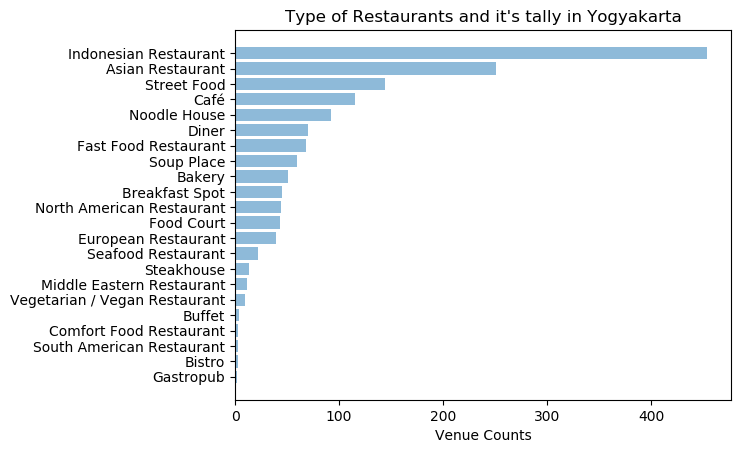

In [37]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

y_pos = np.arange(len(col_one_arr))


plt.barh(y_pos, col_two_arr, align='center', alpha=0.5)
plt.yticks(y_pos, col_one_arr)
plt.xlabel('Venue Counts')
plt.title("Type of Restaurants and it's tally in Yogyakarta")

plt.show()

In [38]:
yog_ven_no_indo_asian=yogyakarta_venues[yogyakarta_venues['Venue Category'] != 'Indonesian Restaurant']

In [39]:
yog_ven_no_indo_asian=yog_ven_no_indo_asian[yog_ven_no_indo_asian['Venue Category'] != 'Asian Restaurant']

#### 3.2.2. Exploring Restaurants

**One hot with Indonesia and Asian Resto**

In [40]:
# one hot encoding
yog_onehot = pd.get_dummies(yogyakarta_venues[['Venue Category']], prefix="", prefix_sep="")

# add location column back to dataframe
yog_onehot['Borough'] = yogyakarta_venues['Borough'] 

# move location column to the first column
fixed_columns = [yog_onehot.columns[-1]] + list(yog_onehot.columns[:-1])
yog_onehot = yog_onehot[fixed_columns]

yog_onehot.head()

,Borough,Asian Restaurant,Bakery,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,Diner,European Restaurant,Fast Food Restaurant,Food Court,Gastropub,Indonesian Restaurant,Middle Eastern Restaurant,Noodle House,North American Restaurant,Seafood Restaurant,Soup Place,South American Restaurant,Steakhouse,Street Food,Vegetarian / Vegan Restaurant
0,Ambarketawang,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,Ambarketawang,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,Ambarketawang,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Ambarketawang,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,Argomulyo,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [41]:
yog_onehot.shape

(1547, 23)

In [42]:
yog_grouped = yog_onehot.groupby('Borough').mean().reset_index()
yog_grouped.head()

,Borough,Asian Restaurant,Bakery,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,Diner,European Restaurant,Fast Food Restaurant,Food Court,Gastropub,Indonesian Restaurant,Middle Eastern Restaurant,Noodle House,North American Restaurant,Seafood Restaurant,Soup Place,South American Restaurant,Steakhouse,Street Food,Vegetarian / Vegan Restaurant
0,Ambarketawang,0.250000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.750000,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0
1,Argomulyo,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.5,0.0,0.00,0.0,0.000000,0.0,0.0,0.50,0.0
2,Argomulyo (Argo Mulyo),0.250000,0.0,0.0,0.0,0.0,0.000000,0.0,0.125000,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.25,0.0,0.000000,0.0,0.0,0.25,0.0
3,Argorejo,0.000000,0.0,0.0,0.0,0.0,0.333333,0.0,0.166667,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.00,0.0,0.166667,0.0,0.0,0.00,0.0
4,Argosari,0.333333,0.0,0.0,0.0,0.0,0.333333,0.0,0.000000,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0


**One hot without Indonesia and Asian Resto**

In [43]:
# one hot encoding
yog_onehot_1 = pd.get_dummies(yog_ven_no_indo_asian[['Venue Category']], prefix="", prefix_sep="")

# add location column back to dataframe
yog_onehot_1['Borough'] = yog_ven_no_indo_asian['Borough'] 

# move location column to the first column
fixed_columns = [yog_onehot_1.columns[-1]] + list(yog_onehot_1.columns[:-1])
yog_onehot_1 = yog_onehot_1[fixed_columns]

yog_onehot_1.head()

,Borough,Bakery,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,Diner,European Restaurant,Fast Food Restaurant,Food Court,Gastropub,Middle Eastern Restaurant,Noodle House,North American Restaurant,Seafood Restaurant,Soup Place,South American Restaurant,Steakhouse,Street Food,Vegetarian / Vegan Restaurant
4,Argomulyo,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5,Argomulyo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,Argomulyo (Argo Mulyo),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,Argomulyo (Argo Mulyo),0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Argomulyo (Argo Mulyo),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [44]:
yog_onehot_1.shape

(842, 21)

In [45]:
yog_grouped_1 = yog_onehot_1.groupby('Borough').mean().reset_index()
yog_grouped_1.head()

,Borough,Bakery,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,Diner,European Restaurant,Fast Food Restaurant,Food Court,Gastropub,Middle Eastern Restaurant,Noodle House,North American Restaurant,Seafood Restaurant,Soup Place,South American Restaurant,Steakhouse,Street Food,Vegetarian / Vegan Restaurant
0,Argomulyo,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.5,0.000000,0.000000,0.0,0.00,0.0,0.0,0.500000,0.000000
1,Argomulyo (Argo Mulyo),0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.400000,0.0,0.00,0.0,0.0,0.400000,0.000000
2,Argorejo,0.0,0.0,0.0,0.0,0.5,0.0,0.250000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.25,0.0,0.0,0.000000,0.000000
3,Argosari,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.000000,0.000000
4,Baciro,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.142857,0.0,0.285714,0.142857,0.0,0.00,0.0,0.0,0.142857,0.142857


### 3.3. Clustering Restaurants

**Clustering without Asian and Indonesian Resto**

In [50]:
# Function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_1 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_1['Borough'] = yog_grouped_1['Borough']

for ind in np.arange(yog_grouped_1.shape[0]):
    neighborhoods_venues_sorted_1.iloc[ind, 1:] = return_most_common_venues(yog_grouped_1.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_1[1:10]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Argomulyo (Argo Mulyo),North American Restaurant,Street Food,Diner,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant
2,Argorejo,Café,Soup Place,Diner,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Breakfast Spot,Buffet,Comfort Food Restaurant,European Restaurant
3,Argosari,Café,Vegetarian / Vegan Restaurant,Street Food,Bistro,Breakfast Spot,Buffet,Comfort Food Restaurant,Diner,European Restaurant,Fast Food Restaurant
4,Baciro,Noodle House,Vegetarian / Vegan Restaurant,North American Restaurant,Gastropub,Street Food,Diner,European Restaurant,Bistro,Breakfast Spot,Buffet
5,Balecatur,Soup Place,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,Diner,European Restaurant
6,Baleharjo,Café,Noodle House,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Breakfast Spot,Buffet,Comfort Food Restaurant,Diner,European Restaurant
7,Banaran,Noodle House,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,Diner,European Restaurant
8,Banguncipto,Diner,Vegetarian / Vegan Restaurant,Street Food,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,European Restaurant,Fast Food Restaurant
9,Bangunjiwo,Breakfast Spot,Noodle House,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Buffet,Café,Comfort Food Restaurant,Diner


**Clustering including Indonesia and Asian Restaurant**

In [49]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = yog_grouped['Borough']

for ind in np.arange(yog_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(yog_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted[1:10]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Argomulyo,Middle Eastern Restaurant,Street Food,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bakery,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant
2,Argomulyo (Argo Mulyo),Asian Restaurant,North American Restaurant,Street Food,Indonesian Restaurant,Diner,European Restaurant,Bakery,Bistro,Breakfast Spot,Buffet
3,Argorejo,Café,Indonesian Restaurant,Soup Place,Diner,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bakery,Bistro,Breakfast Spot,Buffet
4,Argosari,Asian Restaurant,Café,Indonesian Restaurant,Fast Food Restaurant,Bakery,Bistro,Breakfast Spot,Buffet,Comfort Food Restaurant,Diner
5,Baciro,Asian Restaurant,Noodle House,Indonesian Restaurant,Diner,Street Food,Gastropub,Vegetarian / Vegan Restaurant,North American Restaurant,Middle Eastern Restaurant,Seafood Restaurant
6,Balecatur,Indonesian Restaurant,Asian Restaurant,Soup Place,Fast Food Restaurant,Bakery,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant
7,Baleharjo,Indonesian Restaurant,Café,Noodle House,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bakery,Bistro,Breakfast Spot,Buffet,Comfort Food Restaurant
8,Banaran,Noodle House,Indonesian Restaurant,Asian Restaurant,Fast Food Restaurant,Bakery,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant
9,Banguncipto,Diner,Vegetarian / Vegan Restaurant,Street Food,Bakery,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,European Restaurant


### 3.4 Using K-Mode to cluster the groups

In [ ]:
# Finding the best K
!pip install --upgrade kmodes

from kmodes.kmodes import KModes


In [73]:
n_venues_sorted_1_cluster = neighborhoods_venues_sorted_1.drop('Borough', 1)
n_venues_sorted_1_cluster=n_venues_sorted_1_cluster.values

In [83]:
# define function to calculate mean Hamming Distance
def k_mode_distance(data, c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9, c_10, i_centroid, cluster_labels):
    # Calculate Hamming distance for each data point assigned to centroid 
    distances =  [np.array([c_1==_1, c_2==_2, c_3==_3, c_4==_4, c_5==_5, c_6==_6, c_7==_7, c_8==_8, c_9==_9, c_10==_10]) for (_1, _2, _3, _4, _5, _6, _7, _8, _9, _10) in data[i_centroid==cluster_labels]]
    # return the SME value
    return 1-np.mean(distances)

mode_distances_k=[]
# use kmodes to find cluster array and centroid array
for j in range (1,11):
    km=KModes(n_clusters=j,init='Huang',n_init=10,verbose=1)
    clusters=km.fit_predict(n_venues_sorted_1_cluster)
    centroids = km.cluster_centroids_

    # finding mean distances for each k
    c_mode_distances = []
    for i, (c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9, c_10) in enumerate(centroids):
        mode_distance = k_mode_distance(n_venues_sorted_1_cluster, c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9, c_10, i, clusters)
        c_mode_distances.append(mode_distance)
    mode_distances_k.append(np.array(c_mode_distances).mean())
        

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1161.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 1161.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 1161.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 1161.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 1161.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 0, cost: 1161.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 0, cost: 1161.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 8, iteration: 1/100,

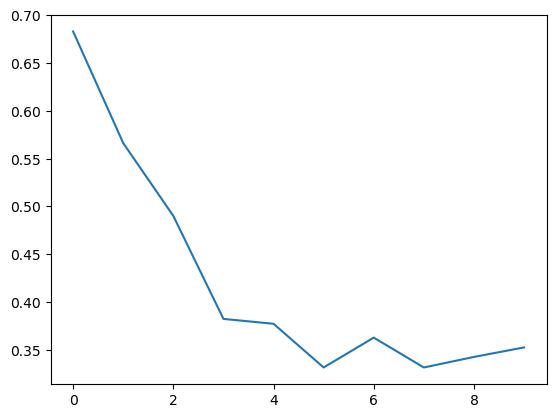

In [84]:
plt.plot(mode_distances_k)

In [117]:
mode_distances_k

[0.6829411764705882,
 0.5662253331084499,
 0.49014243853873224,
 0.3824958353031224,
 0.3773993302057818,
 0.3317328042328042,
 0.3629214413037943,
 0.3317293777194672,
 0.3427350305110603,
 0.3527057210031348]

**Use K=4 from elbow**

In [ ]:
centroids

In [85]:
# define the k-modes model
km = KModes(n_clusters=4, init='Huang', n_init=10, verbose=1)
# fit the clusters to the venues sorted dataframe

n_venues_sorted_1_cluster = neighborhoods_venues_sorted_1.drop('Borough', 1)
clusters = km.fit_predict(n_venues_sorted_1_cluster)
# get an array of cluster modes
kmodes = km.cluster_centroids_
shape = kmodes.shape
label = km.labels_

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 26, cost: 853.0
Run 1, iteration: 2/100, moves: 6, cost: 853.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 20, cost: 772.0
Run 2, iteration: 2/100, moves: 22, cost: 746.0
Run 2, iteration: 3/100, moves: 14, cost: 744.0
Run 2, iteration: 4/100, moves: 2, cost: 744.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 31, cost: 749.0
Run 3, iteration: 2/100, moves: 9, cost: 749.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 41, cost: 799.0
Run 4, iteration: 2/100, moves: 7, cost: 799.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 34, cost: 808.0
Init: initializing centroids
Init: initializing clusters
Starting iterations

In [86]:
kmodes

array([['Noodle House', 'Vegetarian / Vegan Restaurant',
        'Fast Food Restaurant', 'Bistro', 'Breakfast Spot', 'Buffet',
        'Café', 'Comfort Food Restaurant', 'Diner',
        'European Restaurant'],
       ['Café', 'Vegetarian / Vegan Restaurant', 'Street Food', 'Bistro',
        'Breakfast Spot', 'Buffet', 'Comfort Food Restaurant', 'Diner',
        'European Restaurant', 'Fast Food Restaurant'],
       ['Street Food', 'Vegetarian / Vegan Restaurant', 'Bistro',
        'Breakfast Spot', 'Buffet', 'Café', 'Comfort Food Restaurant',
        'Diner', 'European Restaurant', 'Fast Food Restaurant'],
       ['Café', 'Café', 'Vegetarian / Vegan Restaurant',
        'Fast Food Restaurant', 'Bistro', 'Breakfast Spot', 'Buffet',
        'Café', 'Comfort Food Restaurant', 'European Restaurant']],
      dtype='<U29')

In [ ]:
shape

In [ ]:
clusters

#### Further cleaning and joining dataframe

In [89]:
yog_merged = df

# Substitute all empty locations by NAN
for loc in empty_locations:
    yog_merged = yog_merged.replace(loc, np.nan)

# then drop all rows containing NAN
yog_merged.dropna(subset=['Borough'], axis=0, inplace=True)
yog_merged.reset_index(drop=True, inplace=True)
print('Now the cluster dataframe has {0} data rows.'.format(yog_merged.shape[0]))


Now the cluster dataframe has 219 data rows.


In [90]:

yog_merged.drop_duplicates(subset='Borough', keep='first', inplace=True)
if yog_merged['Borough'].unique().shape[0] == yog_merged.shape[0]:
    print('Duplicates were removed successfully.')
print('Now the cluster dataframe has {0} data rows.'.format(yog_merged.shape[0]))    


Duplicates were removed successfully.
Now the cluster dataframe has 207 data rows.


In [91]:
neighborhoods_venues_sorted_1['Cluster Labels']=km.labels_

In [92]:
neighborhoods_venues_sorted_1.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Argomulyo,Middle Eastern Restaurant,Street Food,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,Diner,3
1,Argomulyo (Argo Mulyo),North American Restaurant,Street Food,Diner,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,0
2,Argorejo,Café,Soup Place,Diner,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Breakfast Spot,Buffet,Comfort Food Restaurant,European Restaurant,3
3,Argosari,Café,Vegetarian / Vegan Restaurant,Street Food,Bistro,Breakfast Spot,Buffet,Comfort Food Restaurant,Diner,European Restaurant,Fast Food Restaurant,1
4,Baciro,Noodle House,Vegetarian / Vegan Restaurant,North American Restaurant,Gastropub,Street Food,Diner,European Restaurant,Bistro,Breakfast Spot,Buffet,0


In [93]:
yog_merged = yog_merged.join(neighborhoods_venues_sorted_1.set_index('Borough'), on='Borough')

yog_merged.head()

,Postal Code,Borough,Regency,City,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,55294,Ambarketawang,Gamping,Sleman,-7.805396,110.317874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55752,Argomulyo,Sedayu,Bantul,-7.670610,110.457459,Middle Eastern Restaurant,Street Food,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,Diner,3.0
2,55583,Argomulyo (Argo Mulyo),Cangkringan,Sleman,-7.664847,110.463854,North American Restaurant,Street Food,Diner,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,0.0
3,55752,Argorejo,Sedayu,Bantul,-7.821616,110.262355,Café,Soup Place,Diner,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Breakfast Spot,Buffet,Comfort Food Restaurant,European Restaurant,3.0
4,55752,Argosari,Sedayu,Bantul,-7.813184,110.243059,Café,Vegetarian / Vegan Restaurant,Street Food,Bistro,Breakfast Spot,Buffet,Comfort Food Restaurant,Diner,European Restaurant,Fast Food Restaurant,1.0


In [101]:
yog_merged=yog_merged.dropna()
yog_merged.head()

,Postal Code,Borough,Regency,City,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
1,55752,Argomulyo,Sedayu,Bantul,-7.670610,110.457459,Middle Eastern Restaurant,Street Food,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,Diner,3.0
2,55583,Argomulyo (Argo Mulyo),Cangkringan,Sleman,-7.664847,110.463854,North American Restaurant,Street Food,Diner,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,0.0
3,55752,Argorejo,Sedayu,Bantul,-7.821616,110.262355,Café,Soup Place,Diner,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Breakfast Spot,Buffet,Comfort Food Restaurant,European Restaurant,3.0
4,55752,Argosari,Sedayu,Bantul,-7.813184,110.243059,Café,Vegetarian / Vegan Restaurant,Street Food,Bistro,Breakfast Spot,Buffet,Comfort Food Restaurant,Diner,European Restaurant,Fast Food Restaurant,1.0
5,55225,Baciro,Gondokusuman,Yogyakarta,-7.793470,110.382973,Noodle House,Vegetarian / Vegan Restaurant,North American Restaurant,Gastropub,Street Food,Diner,European Restaurant,Bistro,Breakfast Spot,Buffet,0.0


## 4. Results

### 4.1. Cluster 1

In [102]:
yog_merged.loc[yog_merged['Cluster Labels'] == 0, yog_merged.columns[[1] + list(range(5, yog_merged.shape[1]))]]

,Borough,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
2,Argomulyo (Argo Mulyo),110.463854,North American Restaurant,Street Food,Diner,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,0.0
5,Baciro,110.382973,Noodle House,Vegetarian / Vegan Restaurant,North American Restaurant,Gastropub,Street Food,Diner,European Restaurant,Bistro,Breakfast Spot,Buffet,0.0
6,Balecatur,110.295858,Soup Place,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,Diner,European Restaurant,0.0
13,Banguntapan,110.415824,Soup Place,Diner,North American Restaurant,Café,Street Food,Vegetarian / Vegan Restaurant,European Restaurant,Bistro,Breakfast Spot,Buffet,0.0
14,Banjarsari,110.167138,Street Food,Diner,Vegetarian / Vegan Restaurant,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,European Restaurant,Fast Food Restaurant,0.0
16,Banyuraden,110.336311,Fast Food Restaurant,Soup Place,Vegetarian / Vegan Restaurant,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,Diner,European Restaurant,0.0
17,Banyurejo (Banyu Rejo),110.288118,Breakfast Spot,Noodle House,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Buffet,Café,Comfort Food Restaurant,Diner,European Restaurant,0.0
27,Brontokusuman,110.372077,Fast Food Restaurant,Café,European Restaurant,Vegetarian / Vegan Restaurant,Breakfast Spot,Bakery,Seafood Restaurant,North American Restaurant,Noodle House,Middle Eastern Restaurant,0.0
30,Bumijo,110.359477,Street Food,Noodle House,Bakery,North American Restaurant,Breakfast Spot,European Restaurant,Vegetarian / Vegan Restaurant,Steakhouse,Seafood Restaurant,Middle Eastern Restaurant,0.0
31,Bumirejo,110.196971,Noodle House,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,Diner,European Restaurant,0.0


In [103]:
cluster_1 = yog_merged.loc[yog_merged['Cluster Labels'] == 0, yog_merged.columns[[1] + list(range(5, yog_merged.shape[1]))]]
c_1=cluster_1.describe(include='all')

In [104]:
c_1 

,Borough,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
count,52,52.000000,52,52,52,52,52,52,52,52,52,52,52.0
unique,52,NaN,12,15,12,12,12,13,10,11,10,10,NaN
top,Pendowoharjo,NaN,Noodle House,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,Diner,European Restaurant,NaN
freq,1,NaN,15,19,18,23,27,26,29,28,25,24,NaN
mean,NaN,110.353362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
std,NaN,0.098491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,NaN,110.054827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
25%,NaN,110.325750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
50%,NaN,110.364127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
75%,NaN,110.390700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [105]:
yog_merged.loc[yog_merged['Cluster Labels'] == 1, yog_merged.columns[[1] + list(range(5, yog_merged.shape[1]))]]

,Borough,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
4,Argosari,110.243059,Café,Vegetarian / Vegan Restaurant,Street Food,Bistro,Breakfast Spot,Buffet,Comfort Food Restaurant,Diner,European Restaurant,Fast Food Restaurant,1.0
10,Banguncipto,110.219490,Diner,Vegetarian / Vegan Restaurant,Street Food,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,European Restaurant,Fast Food Restaurant,1.0
18,Baturetno,110.416940,Soup Place,Noodle House,Street Food,Vegetarian / Vegan Restaurant,European Restaurant,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,1.0
33,Caturtunggal (Catur Tunggal),110.388492,Café,Bakery,Street Food,Middle Eastern Restaurant,Breakfast Spot,Diner,European Restaurant,Vegetarian / Vegan Restaurant,Noodle House,North American Restaurant,1.0
36,Condongcatur (Condong Catur),110.403552,Bakery,Café,Street Food,Bistro,Breakfast Spot,Buffet,Comfort Food Restaurant,Diner,European Restaurant,Fast Food Restaurant,1.0
39,Donokerto,110.370172,Café,Vegetarian / Vegan Restaurant,Street Food,Bistro,Breakfast Spot,Buffet,Comfort Food Restaurant,Diner,European Restaurant,Fast Food Restaurant,1.0
41,Gadingharjo,110.265716,Breakfast Spot,Vegetarian / Vegan Restaurant,Street Food,Bistro,Buffet,Café,Comfort Food Restaurant,Diner,European Restaurant,Fast Food Restaurant,1.0
48,Glagah,110.071744,Street Food,Café,Vegetarian / Vegan Restaurant,Bistro,Breakfast Spot,Buffet,Comfort Food Restaurant,Diner,European Restaurant,Fast Food Restaurant,1.0
49,Gowongan,110.365915,Street Food,Café,Noodle House,Food Court,Breakfast Spot,Bakery,Soup Place,Fast Food Restaurant,European Restaurant,North American Restaurant,1.0
59,Kadipaten,110.359273,Café,Bakery,North American Restaurant,Buffet,Noodle House,Food Court,Seafood Restaurant,Soup Place,Middle Eastern Restaurant,Gastropub,1.0


### 4.2. Cluster 2

In [106]:
cluster_2 = yog_merged.loc[yog_merged['Cluster Labels'] == 1, yog_merged.columns[[1] + list(range(5, yog_merged.shape[1]))]]
c_2=cluster_2.describe(include='all')

In [107]:
c_2

,Borough,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
count,37,37.000000,37,37,37,37,37,37,37,37,37,37,37.0
unique,37,NaN,7,6,5,7,7,8,8,9,7,6,NaN
top,Kepuharjo (Kepuh Harjo),NaN,Café,Vegetarian / Vegan Restaurant,Street Food,Bistro,Breakfast Spot,Buffet,Comfort Food Restaurant,Diner,European Restaurant,Fast Food Restaurant,NaN
freq,1,NaN,16,23,30,29,27,24,20,20,30,29,NaN
mean,NaN,110.339055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
std,NaN,0.115064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,NaN,110.071744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
25%,NaN,110.265716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
50%,NaN,110.360710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
75%,NaN,110.398645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


### 4.3. Cluster 3

In [109]:
cluster_3 = yog_merged.loc[yog_merged['Cluster Labels'] == 2, yog_merged.columns[[1] + list(range(5, yog_merged.shape[1]))]]
c_3=cluster_3.describe(include='all')

In [110]:
c_3

,Borough,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
count,29,29.000000,29,29,29,29,29,29,29,29,29,29,29.0
unique,29,NaN,4,10,10,7,9,8,8,8,7,8,NaN
top,Bantul,NaN,Street Food,Vegetarian / Vegan Restaurant,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,Diner,European Restaurant,Fast Food Restaurant,NaN
freq,1,NaN,19,11,17,20,17,19,17,17,17,17,NaN
mean,NaN,110.431176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
std,NaN,0.135289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,NaN,110.208293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
25%,NaN,110.352393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
50%,NaN,110.373471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
75%,NaN,110.485269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


### 4.4. Cluster 4

In [111]:
cluster_4 = yog_merged.loc[yog_merged['Cluster Labels'] == 3, yog_merged.columns[[1] + list(range(5, yog_merged.shape[1]))]]
c_4=cluster_4.describe(include='all')

In [112]:
c_4

,Borough,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
count,40,40.000000,40,40,40,40,40,40,40,40,40,40,40.0
unique,40,NaN,14,15,13,8,8,6,7,8,7,11,NaN
top,Piyaman,NaN,Café,Café,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bistro,Breakfast Spot,Buffet,Café,Comfort Food Restaurant,European Restaurant,NaN
freq,1,NaN,9,9,12,19,29,30,30,21,22,17,NaN
mean,NaN,110.374782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
std,NaN,0.099028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,NaN,110.046405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
25%,NaN,110.334742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
50%,NaN,110.373577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
75%,NaN,110.435756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


### 4.5. Visualization

In [116]:
# create map
map_clusters = folium.Map(location=[yog_lat, yog_lon], zoom_start=10)
kclusters=4
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(yog_merged['Latitude'], yog_merged['Longitude'], yog_merged['Borough'], yog_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    cluster=int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**MAP LEGEND**
<br>Cluster 1 - Red dots
<br>Cluster 2 - Purple dots
<br>Cluster 3 - Blue dots
<br>Cluster 4 - Green dots


## 5. Discussion

From the map we could see some interesting clustering of cuisines in Yogyakarta province. At the city center it include all cluster. **Most of cluster 1 are on the city center, Cluster 2 on the southern part near the beaches, Cluster 3 on the northern part near the highlands, and the 4th Cluster mainly located on the city centers or residential areas.** 
<br>
<br>By looking at every clusters most common venue:
<br>**Cluster 1**:Noodle House, Vegan/Vegetarian Restaurant, Fast Food
<br>**Cluster 2**:Cafe, Vegan/Vegetarian Restaurant, Street Food
<br>**Cluster 3**:Street Food, Vegan/Vegetarian Restaurant, Bistro
<br>**Cluster 4**:Cafe, Cafe, Vegan/Vegetarian Restaurant
<br>We may classify these cluster based on their food price range and group of people qualitatively to make a better and more complete reccomendation. But further research would be very useful to justify this qualitative claim.
<br>
<br>Since restaurant businesses could be categorized as a red ocean markets, opening similar restaurant as the most common restaurant found in that region might be a challenge. But opening a restaurant with the least common type might be a poor decision as well since there might be lack of demands. So we suggest to **choose the 4th to 6th most common venue** as the safe bet as the region is not crowded by the similar type of restaurants but also doesn't show the lack of demands.
<br>
<br>To summarize the discussion, we will show the recommended type of restaurant to be opened on a certain cluster based on the data analysis. To complete the reccomendation, we will add some qualitative reasonings. This qualitative reasonings is only based on one's experience living in Yogyakarta.
<br>
<br>Restaurant Reccomendations:
<br>**Cluster 1**: 
<br>Types: Bistro, Breakfast Spot, Buffet; 
<br>Group of People: All Kinds; 
<br>Price: Low-Medium-High
<br>**Cluster 2**: 
<br>Types: Bistro, Breakfast Spot, Buffet; 
<br>Group of People: Tourist; 
<br>Price: Medium-High
<br>**Cluster 3**: 
<br>Types: Breakfast Spot, Buffet, Cafe; 
<br>Group of People: Tourists; 
<br>Price: Medium-High
<br>**Cluster 4**: 
<br>Types: Fast Food, Bistro and Breakfast Spot; 
<br>Group of People: Students, Residents; 
<br>Price: Low-Medium


## 6. Conclusion

In this study I cluster regions in Yogyakarta province, Indonesia based on food preferences. The food preferences are based on the most common type of restaurants found on 500 meter radius and rank them. I found that the most popular types of restaurant in Yogyakarta with the exception of Indonesian and Asian Restaurant are Street Food, Cafe and Noodle House. But these types of restaurant does not always be the most common types of restaurant on all clusters, this may shows that these restaurants are popular only on certain regions. And Vegan/Vegetarian restaurants are all at the top of the charts on every cluster this may indicate that eventhough the number of Vegan/Vegetarian restaurants are low, they are widely spread all over Yogyakarta. By using *K-modes* clustering, I clustered all of the borough in Yogyakarta into 4 cluster of food preferences. I chose 4 clusters as I saw it as the elbow point and it gives 62 percent accuracy. I hope that this clustering could be useful to determine the types of restaurants to be built and where it should be built. And furthermore maximizing profit.
<br>
<br> This model only gives 62% of accuracy, even by increasing the number of clusters the accuracy only increases to about 65%, although using really big K's would give much better accuracy but the clustering would be too specific. I think there may be better approaches other than the *K-Modes* that was used in this study. Furthermore, more data might be the answer since I observed that small and rural regions does not have many data or even worse, no data at all from the Foursquare API.
<br>
<br>This study also excluded the frequency/number of restaurants on each region since I only cluster the region by ranking. This may cause overvalue-ing regions with lack of data and undervalue-ing regions with lots of data. And more study about other attributes such as prices and group of people is needed to better understand the clustering. Since the foursquare API have limited access to such data, I did not include it in the study.